# <center>Physics-informed neural network</center>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

#### Red neuronal

In [2]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(1 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 6 + 1)
        
        # Parámetros del modelo SIR:
        self.gamma = nn.Parameter(torch.rand(2))  # [asintomáticos, sintomáticos]
        self.kappa = nn.Parameter(torch.rand(2))  # [asintomáticos, sintomáticos]
        self.delta = nn.Parameter(torch.rand(1))
        self.phi = nn.Parameter(torch.rand(1))
    
    def forward(self, input):
        
        for layer in self.inner_layers:
            input = nn.ReLU()(layer(input))
        input = self.last_layer(input)
        
        return input

In [3]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### ODE

In [4]:
from scipy.integrate import solve_ivp
import numpy as np

def generate_data(N_data, T, X0, args, noise = 0.02):
    def _SAIRD(t, X, args):
        # phi: Probability of being asymptomatic
        # Lambda: Infection rate
        # gammaA: Recovery rate for asymptomatic case
        # gammaS: Recovery rate for symptomatic case
        # delta: Death rate
        # kappaA: Inmunity loss rate for asymptomatic case
        # kappaS: Inmunity loss rate for symptomatic case
        phi, Lambda, gammaA, gammaS, delta, kappaA, kappaS = args
        S, Ia, Is, Ra, Rs, D = X
        dS = -Lambda(t)*(Ia+Is)*S + kappaA*Ra + kappaS*Rs
        dIa = phi*Lambda(t)*S*(Ia+Is) - gammaA*Ia
        dIs = (1-phi)*Lambda(t)*S*(Ia+Is) - gammaS*Is - delta*Is
        dRa = gammaA*Ia - kappaA*Ra
        dRs = gammaS*Is - kappaS*Rs
        dD  = delta*Is
        return (dS, dIa, dIs, dRa, dRs, dD)
    solution = solve_ivp(_SAIRD, (0, T), X0[:-1], args = (args,), rtol = 10e-10, atol = 10e-10, dense_output = True)["sol"]
    t = torch.linspace(0, T, N_data)
    ode_solution = torch.tensor(solution(t)).permute(1, 0).float()
    noise = torch.empty(N_data, 3).normal_(noise)
    phi, Lambda, gammaA, gammaS, delta, kappaA, kappaS = args
    L = Lambda(t).unsqueeze(1)
    res_ode_sol = torch.cat([ode_solution, L], axis = 1)
    return (t.unsqueeze(1), res_ode_sol)# + noise)

def Lambda(t):
    return 1 - 1/(1+np.exp(-t))

In [5]:
def SIR(t, net):
    
    s, i_a, i_s, r_a, r_s, d, lambd = net(t).unsqueeze(0).permute(2, 1, 0)
    
    s_ode = derivative(s, t) - (- lambd * s * (i_a + i_s) + net.kappa[0] * r_a + net.kappa[1] * r_s)
    i_a_ode = derivative(i_a, t) - (net.phi * lambd * s * (i_a + i_s) - net.gamma[0] * i_a)
    i_s_ode = derivative(i_s, t) - ((1 - net.phi) * lambd * s * (i_a + i_s) - net.gamma[1] * i_s - net.delta * i_s)
    r_a_ode = derivative(r_a, t) - (net.gamma[0] * i_a - net.kappa[0] * r_a)
    r_s_ode = derivative(r_s, t) - (net.gamma[1] * i_s - net.kappa[1] * r_s)
    d_ode = derivative(d, t) - (net.delta * i_s)
    
    return (s_ode, i_a_ode, i_s_ode, r_a_ode, r_s_ode, d_ode, lambd)


#### Entrenamiento

In [6]:
net = NeuralNetwork(n_layers=8, wide=500)
optimizer = torch.optim.Adam(net.parameters())

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Parámetros del modelo:
T = 5
initial_conditions = (0.9, 0.05, 0.05, 0, 0, 0, Lambda(0))
args = (0.1, Lambda, 3, 1, 0.01, 0.01, 2)

# Parámetros de entrenamiento:
samples_data, samples_phys = 200, 100
epochs = 10000
early_stopping = int(epochs/100)
weights = {'data': 5, 'initial': 4, 'physics': 8}

# Data de entrenamiento (conocida):
t_data, target_data = generate_data(samples_data, T, initial_conditions, args)


# ! ENTRENAMIENTO ----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

try:
    dataset = TensorDataset(t_data, target_data)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    loss_record, patience = [], 0

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for t_data, target_data in dataloader:
            t_data, target_data = t_data.to(device), target_data.to(device)
            optimizer.zero_grad()
            
            # Data conocida:
            s_data, i_a_data, i_s_data, r_a_data, r_s_data, d_data, lambd = net(t_data).unsqueeze(0).permute(2, 1, 0)
            output_data = torch.cat((s_data, i_a_data, i_s_data, r_a_data, r_s_data, d_data, lambd), dim=1)
            loss_data = nn.MSELoss()(output_data, target_data)

            # Condición inicial:
            t_initial = torch.zeros(1, 1, device=device)
            s_initial, i_a_initial, i_s_initial, r_a_initial, r_s_initial, d_initial, lambd_initial = net(t_initial).unsqueeze(0).permute(2, 1, 0)
            output_initial = torch.cat((s_initial, i_a_initial, i_s_initial, r_a_initial, r_s_initial, d_initial, lambd_initial), dim=1).float()
            target_initial = torch.tensor(initial_conditions, device=device).expand_as(output_initial).float()
            loss_initial = nn.MSELoss()(output_initial, target_initial)

            # Modelo:
            t_phys = torch.empty(samples_phys, 1, device=device).uniform_(to=T).requires_grad_()
            output_phys = torch.cat(SIR(t_phys, net), dim=1)
            target_phys = torch.zeros(samples_phys, net.last_layer.out_features, device=device)
            loss_phys = nn.MSELoss()(output_phys, target_phys)

            # Optimización:
            loss = weights['data'] * loss_data + weights['initial'] * loss_initial + weights['physics'] * loss_phys
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        loss_record.append(epoch_loss/len(dataloader))

        if epoch % 1000 == 0:
            print(f'Epoch {epoch} || loss: {loss:.4f}')
        
        # Early stopping:
        if (epoch > 2) and (loss < loss_record[epoch-1] + 1e-3):
            best_model = {'state': net.state_dict(), 'epoch': epoch}
            patience = 0
        elif patience == early_stopping:
            print(f'Early stopping in epoch {epoch}.')
            break
        else:
            patience += 1
            
except KeyboardInterrupt:
    pass

last_model = net.state_dict()
net.load_state_dict(best_model['state'])

Epoch 1000 || loss: 0.0108
Epoch 2000 || loss: 0.0157
Epoch 3000 || loss: 0.0206


<All keys matched successfully>

#### Simulación y comparación con la solución real

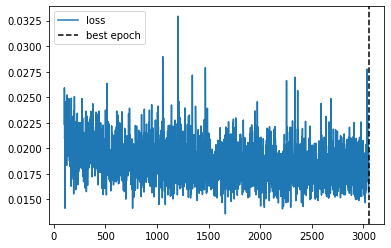

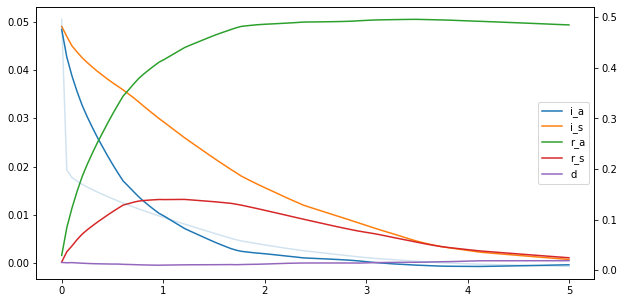

Gamma: 1.8602 | 0.7004
Kappa: 0.0363 | 1.3911
Phi: 0.4496
Delta: 0.0098


In [11]:
net.to('cpu')
net.eval()

# Entrenamiento:
plt.plot(torch.arange(1+100, len(loss_record) + 1), loss_record[100:], label='loss')
plt.axvline(best_model['epoch'], color='k', label='best epoch', linestyle='--')
plt.legend()
plt.show()

# Simulación:

t = torch.linspace(0, T, 100).unsqueeze(1)
s, i_a, i_s, r_a, r_s, d, lambd = net(t).unsqueeze(0).permute(2, 1, 0).detach()

values = {'i_a': i_a,
          'i_s': i_s,
          'r_a': r_a,
          'r_s': r_s,
          'd': d}


fig, ax = plt.subplots(figsize=(10, 5))
for f in values.keys():
    ax.plot(t, values[f], label=f)    

ax_twin = ax.twinx()
ax_twin.plot(t, lambd, label='lambda', alpha = 0.2)

ax.legend()
plt.show()

# Parámetros:
print(f'Gamma: {net.gamma[0].item():.4f} | {net.gamma[1].item():.4f}')
print(f'Kappa: {net.kappa[0].item():.4f} | {net.kappa[1].item():.4f}')
print(f'Phi: {net.phi.item():.4f}')
print(f'Delta: {net.delta.item():.4f}')